In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

import math
import random
from graphviz import Digraph

In [2]:
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad +=other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out
            
    def __rmul__(self, other):
        return self * other
    def tanh(self):
        x= self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) +1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out


    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        # Diğer `Value` nesnesi veya sayı ile çıkarma işlemi
        if isinstance(other, Value):
            out = Value(self.data - other.data, (self, other), '-')
        else:
            out = Value(self.data - other, (self,), '-')
        
        def _backward():
            self.grad += out.grad
            if isinstance(other, Value):
                other.grad += -out.grad
        
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

    def __truediv__(self, other):
        return self * other**-1
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


        

In [3]:
a = Value(2.0)
a-1


Value(data=1.0)

In [4]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'}) # LR: left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node pf n2
        dot.edge(str(id(n1)), str(id(n2)) +n2._op)

    return dot

In [5]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870294653, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' 
o= n.tanh(); o.label = 'o'


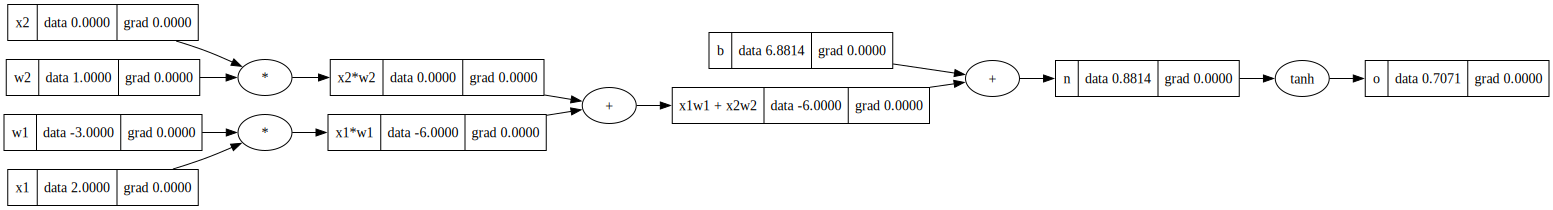

In [6]:
draw_dot(o)

In [7]:
o.backward()

In [8]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870294653]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print ('----')
print ('x2', x2.grad.item())
print ('x1', x1.grad.item())
print ('w1', w1.grad.item())
print ('w2', w2.grad.item())


0.7071066904050358
----
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0


In [274]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))


    def __call__(self, x):
        # w*x+b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w +[self.b]

class Layer: 
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]


    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [275]:
x= [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

[Value(data=-0.8785338097700004)]

In [262]:
n.parameters()

[Value(data=0.4986137365687171),
 Value(data=-0.5289963026526427),
 Value(data=-0.3498514164972577),
 Value(data=0.5704539456735491),
 Value(data=-0.21951516805087135),
 Value(data=-0.027920894157874354),
 Value(data=0.0442286107042531),
 Value(data=-0.7950829692982406),
 Value(data=0.1174607209189702),
 Value(data=-0.8571148846343133),
 Value(data=-0.46529611929049186),
 Value(data=-0.9639517535238808),
 Value(data=-0.26875317882170946),
 Value(data=-0.2687307272319055),
 Value(data=-0.9204618882796054),
 Value(data=0.21958325233301412),
 Value(data=0.6337757074900892),
 Value(data=-0.6592274453509168),
 Value(data=-0.7074241854909946),
 Value(data=-0.26521668424523126),
 Value(data=-0.9257644551547923),
 Value(data=0.6058980717095317),
 Value(data=-0.5628003131987394),
 Value(data=0.07277084774672415),
 Value(data=-0.16597772312802994),
 Value(data=0.8999082719681384),
 Value(data=-0.6789507242673722),
 Value(data=-0.07562309244706134),
 Value(data=0.6294799665077306),
 Value(data=-0

In [272]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, -1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]


In [273]:
ypred = [n(x) for x in xs]
ypred = [v[0] for v in ypred] 
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.6666666666666656)

In [252]:
ypred = [n(x) for x in xs]
ypred = [v[0] for v in ypred] 
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.0018671200197866097)

In [253]:
loss.backward()

In [254]:
for p in n.parameters():
    p.data += -0.01 * p.grad #if we change learning rate 0.01 to 0.1 it makes overstep
    

In [255]:
n.layers[0].neurons[0].w[0].data # checking change

-0.27795619878469385

In [256]:
ypred# last

[Value(data=0.9782068270957673),
 Value(data=-0.9999999999451116),
 Value(data=-0.9999999510108907),
 Value(data=0.9626881033107344)]

In [185]:
ypred#first

[Value(data=0.1957936694461116),
 Value(data=0.014287373857549551),
 Value(data=0.11114487370309131),
 Value(data=0.048803597212215916)]

In [257]:
n.parameters()

[Value(data=-0.27795619878469385),
 Value(data=1.0040736753082693),
 Value(data=-0.8438667206085378),
 Value(data=0.1349975054837034),
 Value(data=3.466935241781141),
 Value(data=-0.9424345695041799),
 Value(data=0.6789281416340224),
 Value(data=-1.1790746942698864),
 Value(data=2.5421695133592364),
 Value(data=-6.207245199699723),
 Value(data=0.8830178886136064),
 Value(data=1.4991374710768997),
 Value(data=-6.811435699660987),
 Value(data=-8.049095458567539),
 Value(data=3.8184951375061456),
 Value(data=-2.4609092505918975),
 Value(data=0.6792487012545988),
 Value(data=0.4252645460821426),
 Value(data=-0.9079680749637502),
 Value(data=0.3786610777902992),
 Value(data=-0.07383269754462628),
 Value(data=-0.017005980839768935),
 Value(data=2.4872087085632595),
 Value(data=-1.1293793620785135),
 Value(data=-0.45863466368967754),
 Value(data=-0.945339001061762),
 Value(data=0.19770310855036516),
 Value(data=-2.270102447259976),
 Value(data=4.473933216115291),
 Value(data=-1.48422511493296

In [294]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    ypred = [v[0] for v in ypred] 
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0 #grad should be zero
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad 

    print(k, loss.data)
    

0 0.010382241666083264
1 0.010322506319901309
2 0.010263363445551486
3 0.01020480480920883
4 0.010146822324164018
5 0.010089408047594343
6 0.010032554177418825
7 0.009976253049235544
8 0.009920497133338015
9 0.009865279031809247
10 0.009810591475689913
11 0.00975642732221936
12 0.009702779552147031
13 0.009649641267112003
14 0.009597005687088576
15 0.009544866147896614
16 0.009493216098774074
17 0.00944204910000982
18 0.009391358820635836
19 0.009341139036176206


In [295]:
ypred

[Value(data=0.9922162734991783),
 Value(data=-0.9662213336574733),
 Value(data=-0.9381692540043526),
 Value(data=0.9342998235338854)]